In [1]:
import os
from os import path

import glob
import pandas as pd
import numpy as np
import wget
from github import Github
import shutil

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime 
import torch

# signal processing
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from scipy.fft import fft
from scipy.ndimage import label as sci_label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz
import scipy

# misc
import warnings

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torcheeg.datasets import DREAMERDataset
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import mean_squared_error, r2_score

# Exploration of Data

In [3]:
stimulus_desc_file = pd.read_excel('ECG_GSR_Emotions/Stimulus_Description.xlsx')
stimulus_desc_file.to_csv('Stimulus_Description.csv', index = None, header=True)
stimulus_desc = pd.read_csv('Stimulus_Description.csv')
stimulus_desc.head()

,Session ID,Video ID,Target Emotion,Title of Video Clip,Time Duration (secs),Active Link of Video
0,1,1,happy,Best Babies Laughing Video Compilation,39,https://drive.google.com/file/d/1ZWD1zyWkHcBI0...
1,1,2,sad,Barely There,39,https://drive.google.com/file/d/13ysQgSsBwy3d8...
2,1,3,neutral,Denali National Park Alaska,39,https://drive.google.com/file/d/1En_ARj18JlBLP...
3,1,4,surprise,World's Highest Commercially Rafted Waterfall,39,https://drive.google.com/file/d/1kCIHXEklgpWds...
4,1,5,disgust,Disgusting video compilation,39,https://drive.google.com/file/d/1mclmT0EAA-oZ6...


In [4]:
self_annotation_multimodal_file = pd.read_excel('ECG_GSR_Emotions/Self-Annotation Labels/Self-annotation Multimodal_Use.xlsx')
self_annotation_multimodal_file.to_csv('Self-annotation Multimodal_Use.csv', index = None, header=True)
self_annotation_multimodal = pd.read_csv('Self-annotation Multimodal_Use.csv')
self_annotation_multimodal['annotation'] = 'M'
self_annotation_multimodal.rename(columns = {'V_Label':'Valence', 'A_Label':'Arousal', 'Four_Labels':'Four_Label'}, inplace = True)
self_annotation_multimodal.head()

,Participant Id,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,Happy,...,Anger,Neutral,Disgust,Surprised,Familiarity Score,Emotion,Valence,Arousal,Four_Label,annotation
0,1,1,1,M_M,13,Female,8,0,0,High,...,VeryLow,VeryLow,VeryLow,VeryLow,Never watched,Happy,HV,LA,HVLA,M
1,1,1,2,M_M,13,Female,4,0,0,VeryLow,...,VeryLow,VeryLow,VeryLow,VeryLow,NaN,Sad,LV,LA,LVLA,M
2,1,1,2,M_M,13,Female,4,0,0,VeryLow,...,VeryLow,VeryLow,VeryLow,Low,NaN,Surprise,LV,LA,LVLA,M
3,1,1,4,M_M,13,Female,9,0,0,VeryHigh,...,VeryLow,VeryLow,VeryLow,VeryLow,NaN,Happy,HV,LA,HVLA,M
4,1,1,5,M_M,13,Female,0,9,0,VeryLow,...,VeryLow,VeryLow,VeryHigh,VeryLow,NaN,Disgust,LV,HA,LVHA,M


In [5]:
self_annotation_singlemodal_file = pd.read_excel('ECG_GSR_Emotions/Self-Annotation Labels/Self-annotation Single Modal_Use.xlsx')
self_annotation_singlemodal_file.to_csv('Self-annotation Single Modal_Use.csv', index = None, header=True)
self_annotation_singlemodal = pd.read_csv('Self-annotation Single Modal_Use.csv')
self_annotation_singlemodal['annotation'] = 'S'
self_annotation_singlemodal.rename(columns = {'Male':'Gender', 'Session Id':'Session ID', 'Video Id':'Video ID'}, inplace = True)
self_annotation_singlemodal.head()

,Participant Id,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,Happy,...,Anger,Neutral,Disgust,Surprised,Familiarity Score,Emotion,Valence,Arousal,Four_Label,annotation
0,1,1,1,M_W,21,Female,6,0,0,Moderate,...,VeryLow,VeryHigh,VeryLow,VeryLow,5,Neutral,HV,LA,HVLA,S
1,1,1,2,M_W,21,Female,2,4,2,VeryLow,...,VeryHigh,VeryLow,Moderate,Moderate,Never watched,Anger,LV,LA,LVLA,S
2,1,1,3,M_W,21,Female,7,6,6,Moderate,...,Low,Moderate,VeryLow,Moderate,Never watched,Mixed,HV,HA,HVHA,S
3,1,1,4,M_W,21,Female,7,3,4,Moderate,...,VeryLow,Low,VeryLow,Low,Never watched,Mixed,HV,LA,HVLA,S
4,1,1,5,M_W,21,Female,0,8,8,VeryLow,...,High,VeryLow,VeryHigh,High,Never watched,Disgust,LV,HA,LVHA,S


In [6]:
self_annotation_frames = [self_annotation_multimodal, self_annotation_singlemodal]
merged_dataframe = pd.concat(self_annotation_frames)
table_frame = merged_dataframe.copy()
table_frame.head()

,Participant Id,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,Happy,...,Anger,Neutral,Disgust,Surprised,Familiarity Score,Emotion,Valence,Arousal,Four_Label,annotation
0,1,1,1,M_M,13,Female,8,0,0,High,...,VeryLow,VeryLow,VeryLow,VeryLow,Never watched,Happy,HV,LA,HVLA,M
1,1,1,2,M_M,13,Female,4,0,0,VeryLow,...,VeryLow,VeryLow,VeryLow,VeryLow,NaN,Sad,LV,LA,LVLA,M
2,1,1,2,M_M,13,Female,4,0,0,VeryLow,...,VeryLow,VeryLow,VeryLow,Low,NaN,Surprise,LV,LA,LVLA,M
3,1,1,4,M_M,13,Female,9,0,0,VeryHigh,...,VeryLow,VeryLow,VeryLow,VeryLow,NaN,Happy,HV,LA,HVLA,M
4,1,1,5,M_M,13,Female,0,9,0,VeryLow,...,VeryLow,VeryLow,VeryHigh,VeryLow,NaN,Disgust,LV,HA,LVHA,M


In [7]:
cols = []
cols.append('Raw Data')
for col in merged_dataframe.columns:
    cols.append(col)

arr_shape = 5000 #this is the max
raw_data_arr = []

def form_data(data_array = [], annotation = '', data_path = ''):
    max_len = 0
    for filename in os.listdir(data_path):
            data = np.loadtxt(os.path.join(data_path, filename), delimiter=',')
            data = data[:arr_shape]
            filenames = filename.split('ECGdata_')[1]
            filenames = filenames.split('.dat')[0]
            filenames = filenames.lower()
            s = filenames.split('s')[1].split('p')
            p = s[1].split('v')
            s = s[0]
            v = p[1]
            p = p[0]
            data_row = merged_dataframe.loc[(merged_dataframe['Session ID'] == int(s)) & 
                             (merged_dataframe['Participant Id'] == int(p)) & 
                             (merged_dataframe['Video ID'] == int(v)) &
                             (merged_dataframe['annotation'] == 'M')]
            stim_row = stimulus_desc.loc[(stimulus_desc['Session ID'] == int(s)) & 
                             (stimulus_desc['Video ID'] == int(v))]
            for index, row in data_row.iterrows():
              data_array.append([data, 
                                   row['Participant Id'], row['Session ID'], row['Video ID'],
                                   row['Name'], row['Age'], row['Gender'], row['Valence level'],
                                   row['Arousal level'], row['Dominance level'], row['Happy'],
                                   row['Sad'], row['Fear'], row['Anger'], row['Neutral'],
                                   row['Disgust'], row['Surprised'], row['Familiarity Score'],
                                   row['Emotion'], row['Valence'], row['Arousal'], row['Four_Label'],
                                   row['annotation'],  stim_row['Target Emotion'].iat[0]
                                   ])
    return data_array

raw_data_arr =  form_data(data_array = raw_data_arr, annotation = 'M', data_path = "ECG_GSR_Emotions/Raw Data/Multimodal/ECG/")
raw_data_arr =  form_data(data_array = raw_data_arr, annotation = 'S', data_path = "ECG_GSR_Emotions/Raw Data/Single Modal/ECG/")
cols.append('Target Emotion')
raw_dataframe = pd.DataFrame(raw_data_arr, columns = cols)
raw_dataframe.rename(columns = {'Participant Id':'Participant ID', 'annotation':'Modal', 'Four_Label':'Four label'}, inplace = True)
raw_dataframe['Familiarity Score'] = raw_dataframe['Familiarity Score'].fillna('Never watched')
raw_dataframe = raw_dataframe.replace(np.nan, '', regex=True)
raw_dataframe.head(2)

,Raw Data,Participant ID,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,...,Neutral,Disgust,Surprised,Familiarity Score,Emotion,Valence,Arousal,Four label,Modal,Target Emotion
0,"[-18.702, -18.694, -18.692, -18.678, -18.665, ...",10,1,1,S_D,8,Male,8,3,0,...,VeryLow,VeryLow,VeryLow,Never watched,Happy,HV,LA,HVLA,M,happy
1,"[-18.702, -18.694, -18.692, -18.678, -18.665, ...",10,1,1,S_D,8,Male,9,7,0,...,VeryLow,VeryLow,VeryLow,Never watched,Happy,HV,HA,HVHA,M,happy


In [8]:
raw_dataframe['Emotion'] = raw_dataframe['Emotion'].str.lower()
raw_dataframe['Target Emotion'] = raw_dataframe['Target Emotion'].str.lower()
len(raw_dataframe[raw_dataframe['Emotion'] == raw_dataframe['Target Emotion']]), len(raw_dataframe)

(174, 399)

In [9]:
def plot_signals(data_arr, title = ''):
    plt.clf()
    plt.figure(figsize=(12, 4))
    
    for index, row in data_arr.iterrows():
        y = row['Raw Data']
        plt.plot(y)
    plt.tight_layout()
    plt.title(title)
    plt.show()

plot_frame = raw_dataframe[raw_dataframe['Emotion'] == raw_dataframe['Target Emotion']].copy()
plot_frame = plot_frame.drop(['Participant ID', 'Session ID', 'Familiarity Score', 'Age', 'Gender', 'Name'], axis = 1)
sad_data = plot_frame.loc[(plot_frame['Emotion'] == 'sad')] 
fear_data = plot_frame.loc[(plot_frame['Emotion'] == 'fear')]
happy_data = plot_frame.loc[(plot_frame['Emotion'] == 'happy')]
anger_data = plot_frame.loc[(plot_frame['Emotion'] == 'anger')]
neutral_data = plot_frame.loc[(plot_frame['Emotion'] == 'neutral')]
mixed_data = plot_frame.loc[(plot_frame['Emotion'] == 'mixed')]
disgust_data = plot_frame.loc[(plot_frame['Emotion'] == 'disgust')]
surprised_data = plot_frame.loc[(plot_frame['Emotion'] == 'surprise')]



<Figure size 640x480 with 0 Axes>

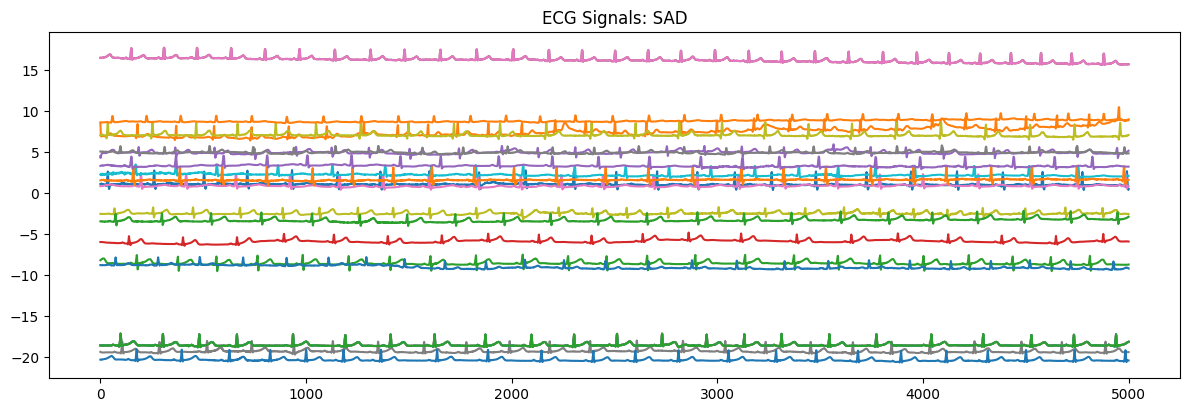

In [10]:
plot_signals(data_arr = sad_data, title = 'ECG Signals: SAD')

<Figure size 640x480 with 0 Axes>

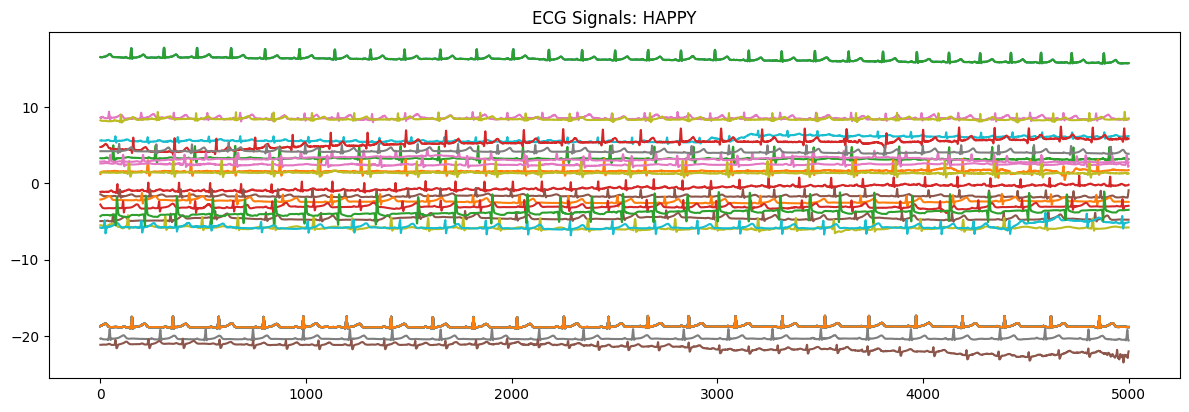

In [11]:
plot_signals(data_arr = happy_data, title = 'ECG Signals: HAPPY')

# Normalizing and Organizing Data

In [12]:
def normalize(data):
    mini = np.min(data)
    maxi = np.max(data)
    return 2 * ((data - mini) / (maxi - mini)) - 1

raw_dataframe['Raw Data'] = raw_dataframe['Raw Data'].apply(lambda x: normalize(x))
raw_dataframe.head()

,Raw Data,Participant ID,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,...,Neutral,Disgust,Surprised,Familiarity Score,Emotion,Valence,Arousal,Four label,Modal,Target Emotion
0,"[-0.5770142180094802, -0.567535545023695, -0.5...",10,1,1,S_D,8,Male,8,3,0,...,VeryLow,VeryLow,VeryLow,Never watched,happy,HV,LA,HVLA,M,happy
1,"[-0.5770142180094802, -0.567535545023695, -0.5...",10,1,1,S_D,8,Male,9,7,0,...,VeryLow,VeryLow,VeryLow,Never watched,happy,HV,HA,HVHA,M,happy
2,"[-0.7351707609346914, -0.7411623726782492, -0....",10,1,2,S_D,8,Male,5,4,2,...,Low,VeryLow,Low,Never watched,mixed,LV,LA,LVLA,M,sad
3,"[-0.7916152897657207, -0.747225647348954, -0.7...",10,1,3,S_D,8,Male,4,0,0,...,VeryHigh,VeryLow,VeryLow,Never watched,neutral,LV,LA,LVLA,M,neutral
4,"[-0.6110134739308721, -0.6110134739308721, -0....",10,1,4,S_D,8,Male,7,6,0,...,VeryLow,VeryLow,VeryHigh,Never watched,surprise,HV,HA,HVHA,M,surprise


In [13]:
raw_dataframe.iloc[0]['Raw Data'].shape

(5000,)

In [14]:
clean_data = raw_dataframe[raw_dataframe['Emotion'] == raw_dataframe['Target Emotion']].copy()

C:\Users\ved67\AppData\Local\Temp\ipykernel_56616\1220316644.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plot_signals(data_arr = clean_data[raw_dataframe['Emotion'] == 'sad'], title = ' normalized ECG Signals: SAD')


<Figure size 640x480 with 0 Axes>

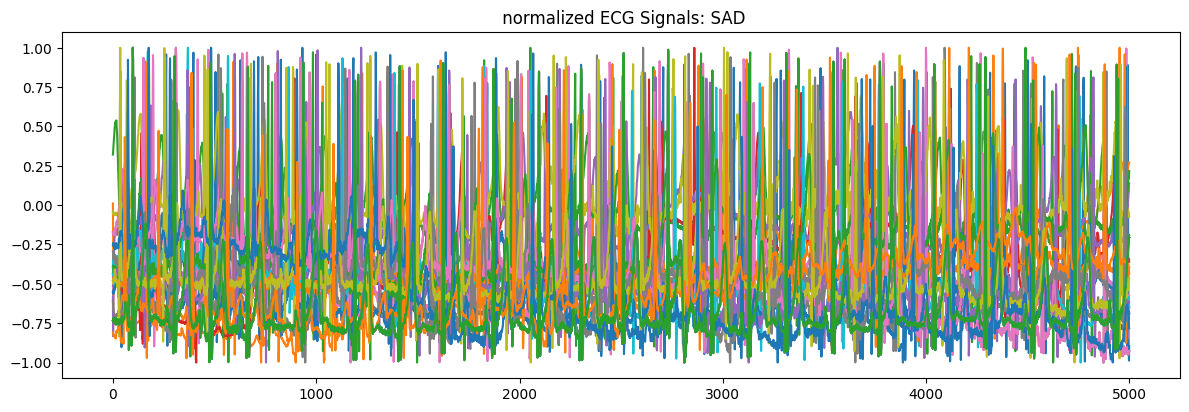

In [15]:
plot_signals(data_arr = clean_data[raw_dataframe['Emotion'] == 'sad'], title = ' normalized ECG Signals: SAD')

In [16]:
#simple model based on target

all_emotions = ['sad', 'fear', 'happy', 'anger', 'neutral', 'mixed', 'disgust', 'surprise']
emotions = ['sad', 'fear', 'happy', 'anger', 'neutral', 'disgust', 'surprise']

def get_emotion_data(data_frame, emotion = 'sad'):
    return data_frame.loc[(data_frame['Emotion'] == emotion)]

x, y = [], []
for emotion in emotions:
    data = get_emotion_data(clean_data, emotion)
    for index, row in data.iterrows():
        x.append(row['Raw Data'])
        y.append(emotions.index(row['Target Emotion']))

x = np.array(x)
y = np.array(y)
x.shape, y.shape

((174, 5000), (174,))

In [17]:
from collections import Counter
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

# 1. First check class distribution
print("Original class distribution:")
print(Counter(y))

Original class distribution:
Counter({2: 43, 1: 33, 5: 27, 0: 23, 3: 18, 4: 16, 6: 14})


In [ ]:
def extract_time_features(signal):
    return np.array([
        np.mean(signal),
        np.std(signal),
        np.max(signal),
        np.min(signal),
        np.median(signal),
        np.percentile(signal, 75) - np.percentile(signal, 25)  # IQR
    ])

#Frequency Domain Features using FFT
def extract_freq_features(signal):
    fft_vals = np.abs(fft(signal))
    # Get first 20 frequency components
    freq_features = fft_vals[:20]
    return freq_features

#Statistical Features
def extract_stat_features(signal):
    return np.array([
        np.mean(signal),
        np.std(signal),
        scipy.stats.skew(signal),
        scipy.stats.kurtosis(signal),
        np.max(signal) - np.min(signal)
    ])

# Create different feature sets
X_time = np.array([extract_time_features(signal) for signal in x])
X_freq = np.array([extract_freq_features(signal) for signal in x])
X_stat = np.array([extract_stat_features(signal) for signal in x])

X_time_train, X_time_test, y_train, y_test = train_test_split(X_time, y, test_size=0.2, random_state=42)
X_freq_train, X_freq_test, _, _ = train_test_split(X_freq, y, test_size=0.2, random_state=42)
X_stat_train, X_stat_test, _, _ = train_test_split(X_stat, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_time_train_scaled = scaler.fit_transform(X_time_train)
X_time_test_scaled = scaler.transform(X_time_test)

scaler_freq = StandardScaler()
X_freq_train_scaled = scaler_freq.fit_transform(X_freq_train)
X_freq_test_scaled = scaler_freq.transform(X_freq_test)

scaler_stat = StandardScaler()
X_stat_train_scaled = scaler_stat.fit_transform(X_stat_train)
X_stat_test_scaled = scaler_stat.transform(X_stat_test)

# Non neural network classifiers

In [ ]:
def evaluate_emotion_classifiers(X_time, X_freq, X_stat, y, output_file="model_results.txt"):
    import time
    from datetime import datetime
    all_results = {}
    
    def run_model(X_train, X_test, y_train, y_test, model_name, feature_type, is_balanced):
        if "SVM" in model_name:
            model = SVC(kernel='rbf', random_state=42)
        else:
            model = RandomForestClassifier(n_estimators=100, random_state=42)
            
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time
        
        y_pred = model.predict(X_test)
        
        results = {
            'accuracy': accuracy_score(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'classification_report': classification_report(y_test, y_pred, 
                                                        target_names=emotions, 
                                                        zero_division=0),
            'training_time': train_time
        }
        return results

    # Split data for all feature types
    splits = {}
    for name, X in [('time', X_time), ('freq', X_freq), ('stat', X_stat)]:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        splits[name] = (X_train_scaled, X_test_scaled, y_train, y_test)


    models = ['SVM', 'RandomForest']
    features = ['time', 'freq', 'stat']
    balance_options = [False, True]

    with open(output_file, 'w') as f:
        f.write(f"Emotion Classification Results - {datetime.now()}\n")
        f.write("="*50 + "\n\n")

        # Store best results
        best_accuracy = 0
        best_config = None

        for feature in features:
            X_train, X_test, y_train, y_test = splits[feature]
            
            for model in models:
                for balanced in balance_options:
                    config_name = f"{model}_{feature}_{'balanced' if balanced else 'unbalanced'}"
                    
                    if balanced:
                        smote = SMOTE(random_state=42)
                        X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
                        results = run_model(X_train_bal, X_test, y_train_bal, y_test, 
                                         model, feature, balanced)
                    else:
                        results = run_model(X_train, X_test, y_train, y_test, 
                                         model, feature, balanced)

                    all_results[config_name] = results
                    
                    # Write detailed results to file
                    f.write(f"\nModel Configuration: {config_name}\n")
                    f.write("-"*30 + "\n")
                    f.write(f"Accuracy: {results['accuracy']:.4f}\n")
                    f.write(f"Training Time: {results['training_time']:.2f} seconds\n")
                    f.write("\nClassification Report:\n")
                    f.write(results['classification_report'])
                    f.write("\nConfusion Matrix:\n")
                    f.write(str(results['confusion_matrix']))
                    f.write("\n" + "="*50 + "\n")
                    
                    # Track best model
                    if results['accuracy'] > best_accuracy:
                        best_accuracy = results['accuracy']
                        best_config = config_name

        # Write summary at the end of file
        f.write("\nSUMMARY OF RESULTS\n")
        f.write("="*50 + "\n")
        f.write("Model Accuracies:\n")
        for config, results in all_results.items():
            f.write(f"{config}: {results['accuracy']:.4f}\n")
        f.write(f"\nBest Model: {best_config} (Accuracy: {best_accuracy:.4f})\n")

    # Print summary to console
    print("\nSummary of Results:")
    print("="*50)
    for config, results in all_results.items():
        print(f"{config}: {results['accuracy']:.4f}")
    print(f"\nBest Model: {best_config} (Accuracy: {best_accuracy:.4f})")
    print(f"\nDetailed results saved to: {output_file}")
    
    return all_results, best_config


results, best_model = evaluate_emotion_classifiers(X_time, X_freq, X_stat, y)


Summary of Results:
SVM_time_unbalanced: 0.1143
SVM_time_balanced: 0.0000
RandomForest_time_unbalanced: 0.4571
RandomForest_time_balanced: 0.5143
SVM_freq_unbalanced: 0.4857
SVM_freq_balanced: 0.4857
RandomForest_freq_unbalanced: 0.5143
RandomForest_freq_balanced: 0.4571
SVM_stat_unbalanced: 0.1143
SVM_stat_balanced: 0.1143
RandomForest_stat_unbalanced: 0.5143
RandomForest_stat_balanced: 0.5429

Best Model: RandomForest_stat_balanced (Accuracy: 0.5429)

Detailed results saved to: model_results.txt


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_stat, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE for balancing
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

# Train Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_bal, y_train_bal)

# Evaluate model
y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=emotions))

import pickle
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

Accuracy: 0.5428571428571428

Classification Report:
              precision    recall  f1-score   support

         sad       0.50      0.17      0.25         6
        fear       0.47      0.78      0.58         9
       happy       0.67      0.80      0.73         5
       anger       0.50      0.25      0.33         4
     neutral       0.50      0.50      0.50         4
     disgust       0.75      0.50      0.60         6
    surprise       0.50      1.00      0.67         1

    accuracy                           0.54        35
   macro avg       0.55      0.57      0.52        35
weighted avg       0.56      0.54      0.51        35



In [ ]:
#Inference

with open('random_forest_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
    
with open('scaler.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)

sample_data = X_test[0:1] 


sample_scaled = loaded_scaler.transform(sample_data)


prediction = loaded_model.predict(sample_scaled)
probabilities = loaded_model.predict_proba(sample_scaled)

print("True label:", y_test[0])
print("Predicted label:", prediction[0])
print("\nProbabilities for each class:")
for emotion, prob in zip(emotions, probabilities[0]):
    print(f"{emotion}: {prob:.3f}")


original_prediction = model.predict(X_test_scaled[0:1])
print("\nVerification - original model prediction:", original_prediction[0])

True label: 5
Predicted label: 5

Probabilities for each class:
sad: 0.000
fear: 0.000
happy: 0.000
anger: 0.000
neutral: 0.000
disgust: 1.000
surprise: 0.000

Verification - original model prediction: 5


# Simple Neural Networks(Does not performan well)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Custom Dataset
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 1. Simple Feed Forward for Statistical Features
class SimpleFFN(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

# 2. CNN for Raw Signal/Frequency Features
class SimpleCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        # Calculate size after convolutions
        self.flatten_size = 32 * (input_size // 4)
        
        self.fc_layers = nn.Sequential(
            nn.Linear(self.flatten_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.conv_layers(x)
        x = x.view(-1, self.flatten_size)
        return self.fc_layers(x)

# 3. Simple RNN for Time Series
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.rnn = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            dropout=0.2
        )
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = x.unsqueeze(2)  # Add feature dimension
        out, _ = self.rnn(x)
        # Use last output
        out = out[:, -1, :]
        return self.fc(out)

def evaluate_neural_networks(X_time, X_freq, X_stat, y, batch_size=32):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    results = {}
    
    # Print class distribution
    print("Class distribution:", np.bincount(y))
    print("Number of classes:", len(np.unique(y)))
    print("Label range:", np.min(y), "to", np.max(y))
    
    feature_sets = {
        'statistical': X_stat,
        'frequency': X_freq,
        'time': X_time
    }
    
    for feature_name, X in feature_sets.items():
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        try:
            train_dataset = ECGDataset(X_train_scaled, y_train)
            test_dataset = ECGDataset(X_test_scaled, y_test)
            
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=batch_size)
            
            if feature_name == 'statistical':
                input_size = X_train_scaled.shape[1]
                model = SimpleFFN(input_size, len(np.unique(y)))
                model_name = 'FFN'
            elif feature_name == 'frequency':
                input_size = X_train_scaled.shape[1]
                model = SimpleCNN(input_size, len(np.unique(y)))
                model_name = 'CNN'
            else:  # time
                model = SimpleRNN(1, 64, len(np.unique(y)))
                model_name = 'RNN'
            
            model = model.to(device)
         
            
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            
            # Verify data batch
            # for batch_x, batch_y in train_loader:
            #     print(f"Batch shapes - X: {batch_x.shape}, y: {batch_y.shape}")
            #     print(f"Label range in batch: {torch.min(batch_y)} to {torch.max(batch_y)}")
            #     break
            
            print(f"\nTraining {model_name} on {feature_name} features:")
            model, history, best_val_acc = train_model(
                model, train_loader, test_loader, criterion, optimizer, 
                num_epochs=50,
                device=device
            )
            
            results[f"{model_name}_{feature_name}"] = {
                'best_val_acc': best_val_acc,
                'history': history
            }
            
        except Exception as e:
            print(f"Error processing {feature_name} features with {model_name}:")
            print(f"Error details: {str(e)}")
            continue
    
    return results


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, device='cpu'):
    try:
        model = model.to(device)
        best_val_acc = 0
        history = {'train_loss': [], 'val_acc': []}
        
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0
            for batch_idx, (inputs, labels) in enumerate(train_loader):
                try:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    
                    train_loss += loss.item()
                    
                except Exception as e:
                    print(f"Error in batch {batch_idx} of epoch {epoch}:")
                    print(f"Input shape: {inputs.shape}")
                    print(f"Labels shape: {labels.shape}")
                    print(f"Error: {str(e)}")
                    raise e
            
            # Validation
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            
            val_acc = 100 * correct / total
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                
            if (epoch + 1) % 25 == 0:  # Print more frequently
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}, Val Acc: {val_acc:.2f}%')
                
            history['train_loss'].append(train_loss/len(train_loader))
            history['val_acc'].append(val_acc)
            
    except Exception as e:
        print("Error in training process:")
        print(str(e))
        raise e
        
    return model, history, best_val_acc

# Run with error checking
try:
    print("Starting neural network evaluation...")
    neural_net_results = evaluate_neural_networks(X_time, X_freq, X_stat, y, batch_size=16)  # Smaller batch size
    print("\nEvaluation completed successfully!")
except Exception as e:
    print("Error in neural network evaluation:")
    print(str(e))

Starting neural network evaluation...
Using device: cuda
Class distribution: [23 33 43 18 16 27 14]
Number of classes: 7
Label range: 0 to 6

Training FFN on statistical features:
Epoch [25/50], Loss: 1.7587, Val Acc: 11.43%
Epoch [50/50], Loss: 1.6325, Val Acc: 11.43%

Training CNN on frequency features:
Epoch [25/50], Loss: 0.9787, Val Acc: 51.43%
Epoch [50/50], Loss: 0.4608, Val Acc: 48.57%

Training RNN on time features:
Epoch [25/50], Loss: 1.8229, Val Acc: 11.43%
Epoch [50/50], Loss: 1.7859, Val Acc: 11.43%

Evaluation completed successfully!


# More complicated data augmentation and neural networks

In [ ]:
class ImprovedFFN(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

class ImprovedCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.AdaptiveAvgPool1d(1)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        x = x.unsqueeze(1)
        if len(x.shape) == 4:
            x = x.squeeze(-1) #batch, in_ch, seq_len
        x = self.conv_layers(x)
        x = x.squeeze(-1)
        return self.fc_layers(x)

class ImprovedRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=2):
        super().__init__()
        
        print("Input size:", input_size)
        print("Hidden size:", hidden_size, "Layers:", num_layers, "Classes:", num_classes)
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.3,
            bidirectional=True
        )
        
        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, num_classes)
        )
    
    def forward(self, x):
        
        batch_size = x.size(0)
        
        if len(x.shape) == 2:
            # Add feature dimension
            x = x.unsqueeze(2)
            
        # LSTM forward pass
        lstm_output, _ = self.lstm(x)
        # Use last output with layer norm
        last_output = self.layer_norm(lstm_output[:, -1, :])
        # Classification
        output = self.fc(last_output)
        return output

In [66]:
import copy
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, device='cpu'):
    model = model.to(device)
    best_val_acc = 0
    best_model = None
    patience = 10
    no_improve = 0
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', 
                                                         factor=0.5, patience=5)
    data_item = next(iter(train_loader))
    print(f"Input shape: {data_item[0].shape}")
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_acc = 100 * correct / total
        
        # Validation
        val_acc = validate_model(model, val_loader, device)
        scheduler.step(val_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = copy.deepcopy(model)
            no_improve = 0
        else:
            no_improve += 1
            
        if no_improve >= patience:
            print(f'Early stopping at epoch {epoch}')
            break
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}, '
                  f'Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')
    
    return best_model, {'train_loss': train_loss/len(train_loader), 'val_acc': best_val_acc}
def validate_model(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [67]:
import random
class AugmentedECGDataset(Dataset):
    def __init__(self, X, y, is_temporal=False):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        self.is_temporal = is_temporal
        self.training = False
        
    def __len__(self):
        return len(self.y)
    
    def augment(self, signal):
        # Add random noise
        if random.random() > 0.5:
            noise = torch.randn_like(signal) * 0.05
            signal = signal + noise
        
        # Random scaling
        if random.random() > 0.5:
            scale = random.uniform(0.95, 1.05)
            signal = signal * scale
            
        return signal
    
    def __getitem__(self, idx):
        signal = self.X[idx]
        if self.training:
            signal = self.augment(signal)
            
        # For temporal data (like time series), reshape to (timesteps, 1)
        if self.is_temporal:
            signal = signal.view(-1, 1)
            
        return signal, self.y[idx]

In [ ]:
SEED = 123456
torch.manual_seed(SEED)
np.random.seed(SEED)
def evaluate_all_combinations(X_time, X_freq, X_stat, y, batch_size=32):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    results = {}
    
    # Calculate class weights for balanced loss
    class_counts = np.bincount(y)
    class_weights = torch.FloatTensor(1.0 / class_counts)
    class_weights = class_weights.to(device)
    

    feature_sets = {
        'statistical': X_stat,
        'frequency': X_freq,
        'time': X_time
    }
    

    model_types = {
        'FFN': ImprovedFFN,
        'CNN': ImprovedCNN,
        'RNN': ImprovedRNN
    }
    
    for feature_name, X in feature_sets.items():
    
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)
        
        for model_name, ModelClass in model_types.items():
            print(f"\nTraining {model_name} on {feature_name} features")
            
            is_temporal = feature_name == 'time'
            train_dataset = AugmentedECGDataset(X_train_scaled, y_train, is_temporal=is_temporal)
            train_dataset.training = True
            val_dataset = AugmentedECGDataset(X_val_scaled, y_val, is_temporal=is_temporal)
            test_dataset = AugmentedECGDataset(X_test_scaled, y_test, is_temporal=is_temporal)
            val_dataset.training = False
            test_dataset.training = False
            
    
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size)
            test_loader = DataLoader(test_dataset, batch_size=batch_size)
            

            input_size = X_train_scaled.shape[1]
            data_item = next(iter(train_loader))
            num_classes = len(np.unique(y))
            
            if model_name == 'RNN':
                model = ModelClass(input_size, 64, num_classes)
            else:
                model = ModelClass(input_size, num_classes)
            

            criterion = nn.CrossEntropyLoss(weight=class_weights)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
            
            try:
                model, history = train_model(
                    model, train_loader, val_loader, criterion, optimizer,
                    num_epochs=100,
                    device=device
                )

                test_acc = validate_model(model, test_loader, device)

                results[f"{model_name}_{feature_name}"] = {
                    'model': model,
                    'history': history,
                    'test_acc': test_acc,
                    'scaler': scaler
                }
                torch.save(model.state_dict(), f"{model_name}_{feature_name}_{SEED}.pt")
                print(f"Test Accuracy: {test_acc:.2f}%")
                
            except Exception as e:
                print(f"Error training {model_name} on {feature_name} features:")
                print(str(e))
                continue
    

    print("\nSummary of all combinations:")
    print("-" * 50)
    for combo, result in results.items():
        print(f"{combo}: {result['test_acc']:.2f}%")
    

    best_combo = max(results.items(), key=lambda x: x[1]['test_acc'])
    print(f"\nBest combination: {best_combo[0]} with accuracy {best_combo[1]['test_acc']:.2f}%")
    
    return results


try:
    print("Starting evaluation of all model-feature combinations...")
    all_results = evaluate_all_combinations(X_time, X_freq, X_stat, y, batch_size=16)
except Exception as e:
    print("Error in evaluation:")
    print(str(e))

Starting evaluation of all model-feature combinations...
Using device: cuda

Training FFN on statistical features
Input shape: torch.Size([16, 5])
Epoch [10/100], Loss: 1.6960, Train Acc: 35.54%, Val Acc: 42.31%
Early stopping at epoch 18
Test Accuracy: 40.74%

Training CNN on statistical features
Input shape: torch.Size([16, 5])
Epoch [10/100], Loss: 1.2181, Train Acc: 57.85%, Val Acc: 42.31%
Epoch [20/100], Loss: 1.1142, Train Acc: 61.98%, Val Acc: 50.00%
Early stopping at epoch 25
Test Accuracy: 44.44%

Training RNN on statistical features
Input size: 5
Hidden size: 64 Layers: 2 Classes: 7
Input shape: torch.Size([16, 5])
Epoch [10/100], Loss: 1.9232, Train Acc: 21.49%, Val Acc: 15.38%
Early stopping at epoch 17
Test Accuracy: 18.52%

Training FFN on frequency features
Input shape: torch.Size([16, 20])
Epoch [10/100], Loss: 1.0638, Train Acc: 66.12%, Val Acc: 42.31%


c:\Users\ved67\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Early stopping at epoch 13
Test Accuracy: 29.63%

Training CNN on frequency features
Input shape: torch.Size([16, 20])
Epoch [10/100], Loss: 0.5171, Train Acc: 83.47%, Val Acc: 46.15%
Early stopping at epoch 15
Test Accuracy: 37.04%

Training RNN on frequency features
Input size: 20
Hidden size: 64 Layers: 2 Classes: 7
Input shape: torch.Size([16, 20])
Epoch [10/100], Loss: 1.8724, Train Acc: 19.01%, Val Acc: 26.92%
Epoch [20/100], Loss: 1.7685, Train Acc: 28.10%, Val Acc: 26.92%
Epoch [30/100], Loss: 1.6839, Train Acc: 44.63%, Val Acc: 34.62%
Early stopping at epoch 30
Test Accuracy: 25.93%

Training FFN on time features
Input shape: torch.Size([16, 6, 1])


c:\Users\ved67\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Epoch [10/100], Loss: 1.7199, Train Acc: 30.58%, Val Acc: 23.08%
Epoch [20/100], Loss: 1.6270, Train Acc: 39.67%, Val Acc: 34.62%
Early stopping at epoch 20
Test Accuracy: 25.93%

Training CNN on time features
Input shape: torch.Size([16, 6, 1])
Epoch [10/100], Loss: 1.2588, Train Acc: 56.20%, Val Acc: 34.62%
Epoch [20/100], Loss: 1.0385, Train Acc: 68.60%, Val Acc: 50.00%
Early stopping at epoch 25
Test Accuracy: 48.15%

Training RNN on time features
Input size: 6
Hidden size: 64 Layers: 2 Classes: 7
Input shape: torch.Size([16, 6, 1])
Epoch [10/100], Loss: 1.9485, Train Acc: 15.70%, Val Acc: 0.00%
Early stopping at epoch 10
Test Accuracy: 14.81%

Summary of all combinations:
--------------------------------------------------
FFN_statistical: 40.74%
CNN_statistical: 44.44%
RNN_statistical: 18.52%
FFN_frequency: 29.63%
CNN_frequency: 37.04%
RNN_frequency: 25.93%
FFN_time: 25.93%
CNN_time: 48.15%
RNN_time: 14.81%

Best combination: CNN_time with accuracy 48.15%


c:\Users\ved67\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


In [ ]:
SEED = 3343
torch.manual_seed(SEED)
np.random.seed(SEED)
def evaluate_all_combinations(X_time, X_freq, X_stat, y, batch_size=32):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    results = {}

    class_counts = np.bincount(y)
    class_weights = torch.FloatTensor(1.0 / class_counts)
    class_weights = class_weights.to(device)

    feature_sets = {
        'statistical': X_stat,
        'frequency': X_freq,
        'time': X_time
    }

    model_types = {
        'FFN': ImprovedFFN,
        'CNN': ImprovedCNN,
        'RNN': ImprovedRNN
    }
    
    for feature_name, X in feature_sets.items():

        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)
        
        for model_name, ModelClass in model_types.items():
            print(f"\nTraining {model_name} on {feature_name} features")
            
            is_temporal = feature_name == 'time'
            train_dataset = AugmentedECGDataset(X_train_scaled, y_train, is_temporal=is_temporal)
            train_dataset.training = True
            val_dataset = AugmentedECGDataset(X_val_scaled, y_val, is_temporal=is_temporal)
            test_dataset = AugmentedECGDataset(X_test_scaled, y_test, is_temporal=is_temporal)
            val_dataset.training = False
            test_dataset.training = False
            
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size)
            test_loader = DataLoader(test_dataset, batch_size=batch_size)
            
            input_size = X_train_scaled.shape[1]
            data_item = next(iter(train_loader))
            num_classes = len(np.unique(y))
            
            if model_name == 'RNN':
                model = ModelClass(input_size, 64, num_classes)
            else:
                model = ModelClass(input_size, num_classes)
            
            criterion = nn.CrossEntropyLoss(weight=class_weights)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
            
            try:
                model, history = train_model(
                    model, train_loader, val_loader, criterion, optimizer,
                    num_epochs=100,
                    device=device
                )
                
                test_acc = validate_model(model, test_loader, device)
                
                # Store results
                results[f"{model_name}_{feature_name}"] = {
                    'model': model,
                    'history': history,
                    'test_acc': test_acc,
                    'scaler': scaler
                }
                torch.save(model.state_dict(), f"{model_name}_{feature_name}_{SEED}.pt")
                print(f"Test Accuracy: {test_acc:.2f}%")
                
            except Exception as e:
                print(f"Error training {model_name} on {feature_name} features:")
                print(str(e))
                continue
    
    print("\nSummary of all combinations:")
    print("-" * 50)
    for combo, result in results.items():
        print(f"{combo}: {result['test_acc']:.2f}%")
    
    best_combo = max(results.items(), key=lambda x: x[1]['test_acc'])
    print(f"\nBest combination: {best_combo[0]} with accuracy {best_combo[1]['test_acc']:.2f}%")
    
    return results

# Run everything
try:
    print("Starting evaluation of all model-feature combinations...")
    all_results = evaluate_all_combinations(X_time, X_freq, X_stat, y, batch_size=16)
except Exception as e:
    print("Error in evaluation:")
    print(str(e))

Starting evaluation of all model-feature combinations...
Using device: cuda

Training FFN on statistical features
Input shape: torch.Size([16, 5])
Epoch [10/100], Loss: 1.6606, Train Acc: 32.23%, Val Acc: 38.46%
Epoch [20/100], Loss: 1.4524, Train Acc: 42.15%, Val Acc: 46.15%
Epoch [30/100], Loss: 1.4802, Train Acc: 45.45%, Val Acc: 46.15%
Early stopping at epoch 34
Test Accuracy: 40.74%

Training CNN on statistical features
Input shape: torch.Size([16, 5])
Epoch [10/100], Loss: 1.2673, Train Acc: 55.37%, Val Acc: 42.31%
Epoch [20/100], Loss: 0.9373, Train Acc: 61.16%, Val Acc: 50.00%
Early stopping at epoch 20
Test Accuracy: 48.15%

Training RNN on statistical features
Input size: 5
Hidden size: 64 Layers: 2 Classes: 7
Input shape: torch.Size([16, 5])
Epoch [10/100], Loss: 1.9764, Train Acc: 19.01%, Val Acc: 11.54%
Early stopping at epoch 13
Test Accuracy: 18.52%

Training FFN on frequency features
Input shape: torch.Size([16, 20])


c:\Users\ved67\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Epoch [10/100], Loss: 1.0987, Train Acc: 61.16%, Val Acc: 46.15%
Early stopping at epoch 19
Test Accuracy: 33.33%

Training CNN on frequency features
Input shape: torch.Size([16, 20])
Epoch [10/100], Loss: 0.5820, Train Acc: 87.60%, Val Acc: 50.00%
Early stopping at epoch 15
Test Accuracy: 37.04%

Training RNN on frequency features
Input size: 20
Hidden size: 64 Layers: 2 Classes: 7
Input shape: torch.Size([16, 20])
Epoch [10/100], Loss: 1.7981, Train Acc: 33.06%, Val Acc: 23.08%
Early stopping at epoch 10
Test Accuracy: 33.33%

Training FFN on time features
Input shape: torch.Size([16, 6, 1])


c:\Users\ved67\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Epoch [10/100], Loss: 1.6095, Train Acc: 38.84%, Val Acc: 26.92%
Early stopping at epoch 13
Test Accuracy: 25.93%

Training CNN on time features
Input shape: torch.Size([16, 6, 1])
Epoch [10/100], Loss: 1.3089, Train Acc: 48.76%, Val Acc: 38.46%
Epoch [20/100], Loss: 0.9671, Train Acc: 63.64%, Val Acc: 38.46%
Early stopping at epoch 22
Test Accuracy: 44.44%

Training RNN on time features
Input size: 6
Hidden size: 64 Layers: 2 Classes: 7
Input shape: torch.Size([16, 6, 1])
Epoch [10/100], Loss: 1.8767, Train Acc: 19.83%, Val Acc: 23.08%
Epoch [20/100], Loss: 1.9628, Train Acc: 15.70%, Val Acc: 15.38%
Early stopping at epoch 26
Test Accuracy: 22.22%

Summary of all combinations:
--------------------------------------------------
FFN_statistical: 40.74%
CNN_statistical: 48.15%
RNN_statistical: 18.52%
FFN_frequency: 33.33%
CNN_frequency: 37.04%
RNN_frequency: 33.33%
FFN_time: 25.93%
CNN_time: 44.44%
RNN_time: 22.22%

Best combination: CNN_statistical with accuracy 48.15%


c:\Users\ved67\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
